Import du csv et traitement

In [1]:
import pandas as pd

# Spécifie le chemin vers ton fichier CSV
chemin_fichier_csv = 'https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz'

# Définis la taille des chunks (nombre de lignes par chunk)
chunksize = 10000  # Par exemple, 10000 lignes par chunk
listedechunk = []

# Colonnes sélectionnées
selected_cols = [
    "code",
    "product_name",
    "created_datetime",
    "quantity",
    "brands",
    "categories",
    'categories_en',
    'pnns_groups_1',
    'pnns_groups_2',
    'main_category_en',
    "ingredients_text",
    "nutriscore_score",
    "nutriscore_grade",
    "countries_en",
    "energy-kj_100g",
    "energy-kcal_100g",
    "fat_100g",
    "saturated-fat_100g",
    "omega-3-fat_100g",
    "omega-6-fat_100g",
    "sugars_100g",
    "added-sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
    "nutrition-score-fr_100g"
]

# Parcourt le fichier CSV en utilisant les chunks
for i, chunk in enumerate(pd.read_csv(chemin_fichier_csv, sep="\t", chunksize=chunksize, compression='gzip', on_bad_lines="skip", low_memory=False)):
    # Sélectionne les colonnes nécessaires dans chaque chunk
    chunk = chunk[selected_cols]
   # Convertir la colonne 'created_datetime' en datetime
    chunk.loc[:, 'created_datetime'] = pd.to_datetime(chunk['created_datetime'], errors='coerce')

    # Ajoute le chunk traité à la liste
    listedechunk.append(chunk)



Traitement du csv

In [2]:
# Parcourt les chunks déjà stockés dans listedechunk
for i in range(len(listedechunk)):
    chunk = listedechunk[i]  # Récupère le chunk actuel

    # Supprime les lignes où nutriscore_grade est 'unknown' ou 'not-applicable'
    chunk = chunk[chunk['nutriscore_grade'].isin(['a', 'b', 'c', 'd', 'e'])]
    # Remplace le chunk original par le chunk nettoyé
    listedechunk[i] = chunk


Test sur un chunk

In [3]:
if listedechunk:
    premier_chunk = listedechunk[0]
    premier_chunk.to_csv('premier_chunk.csv', index=False)  # Enregistre sans les index
    print("Le premier chunk a été enregistré dans 'premier_chunk.csv'.")
else:
    print("Aucun chunk n'a été chargé.")

Le premier chunk a été enregistré dans 'premier_chunk.csv'.


In [4]:
# Concatène tous les chunks en un seul DataFrame
df_concatene = pd.concat(listedechunk)

#vire les colonnes vide de 90%
threshold= len(df_concatene)*0.1
df_concatene = df_concatene.dropna(thresh=threshold, axis=1)




Faire avec les pays

In [5]:

import pycountry

# Crée un ensemble de pays valides
valid_countries = set(country.name for country in pycountry.countries)


def filter_valid_countries(countries_str):
    if pd.isnull(countries_str):  # Vérifie si la chaîne est None
        return ['unknown']
    
    countries = countries_str.split(',')
    return [country for country in countries if country in valid_countries]

# Appliquer la fonction sur la colonne countries_en
df_concatene['countries_en'] = df_concatene['countries_en'].apply(filter_valid_countries)

# Remplir les lignes vides par 'unknown'
df_concatene['countries_en'] = df_concatene['countries_en'].apply(lambda x: x if x else ['unknown'])

# Sauvegarde le DataFrame final dans un fichier CSV
df_concatene.to_csv('fichier_concatene_avecpays.csv', index=False)


On fait des plot

Index(['code', 'product_name', 'created_datetime', 'quantity', 'brands',
       'categories', 'categories_en', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_en', 'ingredients_text', 'nutriscore_score',
       'nutriscore_grade', 'countries_en', 'energy-kj_100g',
       'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g', 'created_year'],
      dtype='object')
datetime64[ns, UTC]


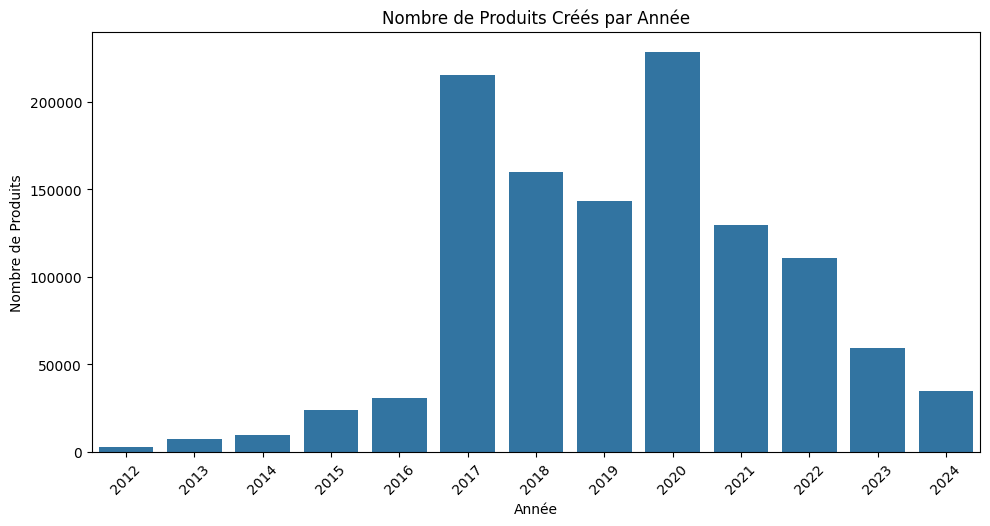

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que df_concatene a été créé précédemment

# 1. Convertir 'created_datetime' en datetime
df_concatene['created_datetime'] = pd.to_datetime(df_concatene['created_datetime'], errors='coerce')

# 2. Extraire l'année seulement
df_concatene['created_year'] = df_concatene['created_datetime'].dt.year
df_concatene = df_concatene.dropna(subset=['created_year'])  # Supprime les lignes sans année

# Vérifie les colonnes et les types de données
print(df_concatene.columns)
print(df_concatene['created_datetime'].dtype)

# 3. Aplatir la colonne 'countries_en'
df_concatene_exploded = df_concatene.explode('countries_en')

# 4. Graphique de création des produits par année (bar graph)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_concatene, x='created_year')
plt.title('Nombre de Produits Créés par Année')
plt.xlabel('Année')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=45)

# Ajustements supplémentaires
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)  # Ajuste les marges inférieure et supérieure

plt.show()



Répartition des Produits par Pays:
countries_en
France                            425924
United States                     316019
Germany                            94155
Spain                              92767
Italy                              78749
                                   ...  
Liberia                                1
Timor-Leste                            1
Papua New Guinea                       1
British Indian Ocean Territory         1
Cook Islands                           1
Name: count, Length: 187, dtype: int64


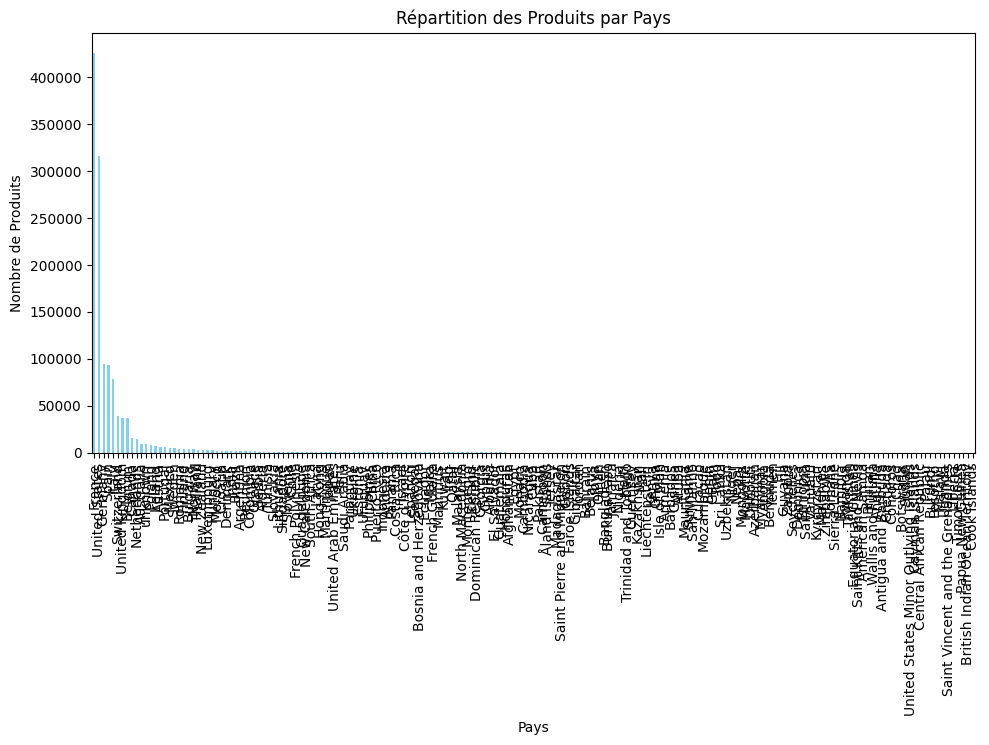

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# 3. Aplatir la colonne 'countries_en'
df_concatene_exploded = df_concatene.explode('countries_en')



# 5. Tableau de répartition par pays
country_distribution = df_concatene_exploded['countries_en'].value_counts()

# Affichage du tableau
print("Répartition des Produits par Pays:")
print(country_distribution)

# Optionnel: Afficher un graphique de la répartition par pays
plt.figure(figsize=(10, 6))
country_distribution.plot(kind='bar', color='skyblue')
plt.title('Répartition des Produits par Pays')
plt.xlabel('Pays')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)  # Ajuste les marges inférieure et supérieure

plt.show()


plot pnaas grpoup etc


Répartition des Produits par pnns_groups_1:
pnns_groups_1
Sugary snacks              201203
unknown                    190765
Fish Meat Eggs             134101
Milk and dairy products    130443
Cereals and potatoes       127452
Fat and sauces              93158
Beverages                   81531
Composite foods             75883
Fruits and vegetables       64308
Salty snacks                57731
Alcoholic beverages            83
Name: count, dtype: int64


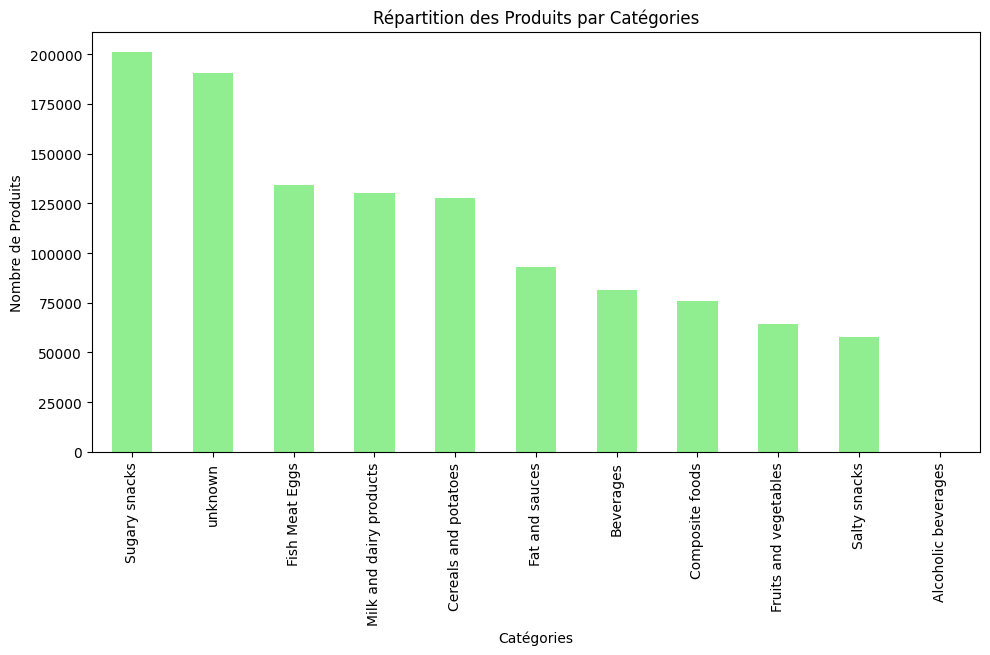

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# 4. Aplatir les catégories si nécessaire

df_concatene_exploded = df_concatene.explode('pnns_groups_1')



# 7. Tableau de répartition des catégories
category_distribution = df_concatene_exploded['pnns_groups_1'].value_counts()

print("Répartition des Produits par pnns_groups_1:")
print(category_distribution)
# Optionnel: Afficher un graphique de la répartition par catégories
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar', color='lightgreen')
plt.title('Répartition des Produits par Catégories')
plt.xlabel('Catégories')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)  # Ajuste les marges inférieure et supérieure
plt.show()


Répartition des Produits par pnns_groups_2:
pnns_groups_2
unknown                             190765
Biscuits and cakes                   85112
Sweets                               82673
Dressings and sauces                 65342
Cheese                               61367
Cereals                              56504
One-dish meals                       55251
Processed meat                       52818
Milk and yogurt                      43870
Meat                                 38037
Fish and seafood                     37698
Bread                                34705
Vegetables                           34468
Fats                                 27816
Sweetened beverages                  23922
Appetizers                           23044
Chocolate products                   22962
Salty and fatty products             22200
Breakfast cereals                    17838
Fruits                               17447
Legumes                              14284
Pizza pies and quiches               13

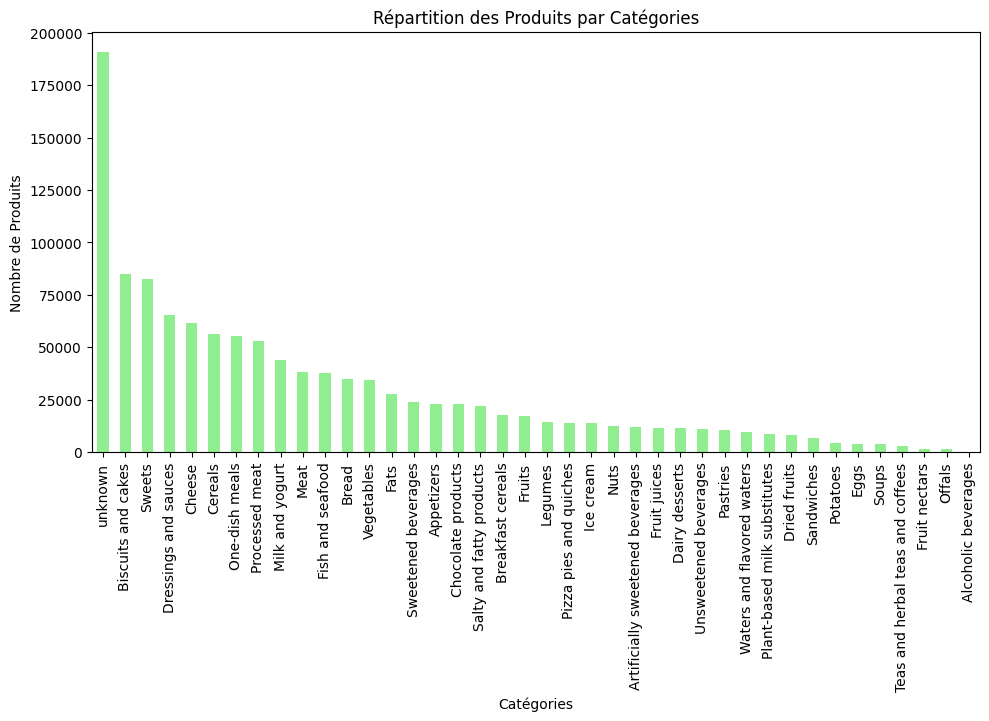

In [9]:

df_concatene_exploded = df_concatene_exploded.explode('pnns_groups_2')

# 7. Tableau de répartition des catégories
category_distribution = df_concatene_exploded['pnns_groups_2'].value_counts()

print("Répartition des Produits par pnns_groups_2:")
print(category_distribution)
# Optionnel: Afficher un graphique de la répartition par catégories
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar', color='lightgreen')
plt.title('Répartition des Produits par Catégories')
plt.xlabel('Catégories')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)  # Ajuste les marges inférieure et supérieure
plt.show()




Graph demandés


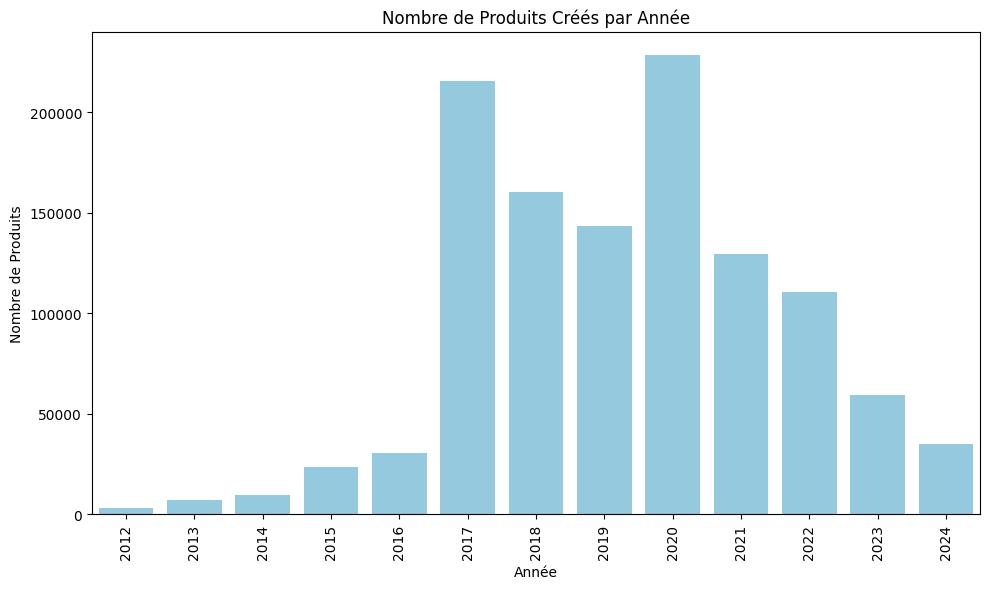

Répartition des Produits par Pays:
countries_en
France                            425924
United States                     316019
Germany                            94155
Spain                              92767
Italy                              78749
                                   ...  
Liberia                                1
Timor-Leste                            1
Papua New Guinea                       1
British Indian Ocean Territory         1
Cook Islands                           1
Name: count, Length: 187, dtype: int64


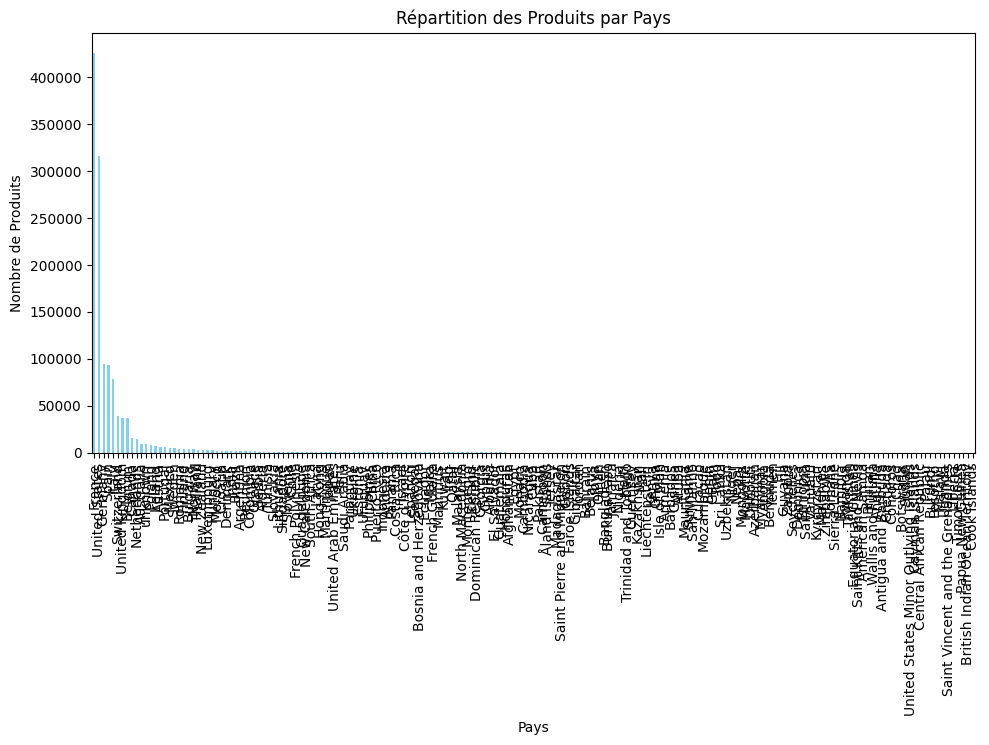

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Extraire uniquement l'année de la date de création
df_concatene_exploded['created_datetime'] = pd.to_datetime(df_concatene_exploded['created_datetime'], errors='coerce')
df_concatene_exploded['created_year'] = df_concatene_exploded['created_datetime'].dt.year

# Supprimer les lignes sans année
df_concatene_exploded = df_concatene_exploded.dropna(subset=['created_year'])

# Créer un bargraph pour les créations de produits par année
plt.figure(figsize=(10, 6))
sns.countplot(data=df_concatene_exploded, x='created_year', color='skyblue')
plt.title('Nombre de Produits Créés par Année')
plt.xlabel('Année')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Aplatir la colonne 'countries_en'
df_concatene_exploded = df_concatene.explode('countries_en')
# 5. Tableau de répartition par pays
country_distribution = df_concatene_exploded['countries_en'].value_counts()

# Affichage du tableau
print("Répartition des Produits par Pays:")
print(country_distribution)

# Optionnel: Afficher un graphique de la répartition par pays
plt.figure(figsize=(10, 6))
country_distribution.plot(kind='bar', color='skyblue')
plt.title('Répartition des Produits par Pays')
plt.xlabel('Pays')
plt.ylabel('Nombre de Produits')
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)  # Ajuste les marges inférieure et supérieure

plt.show()

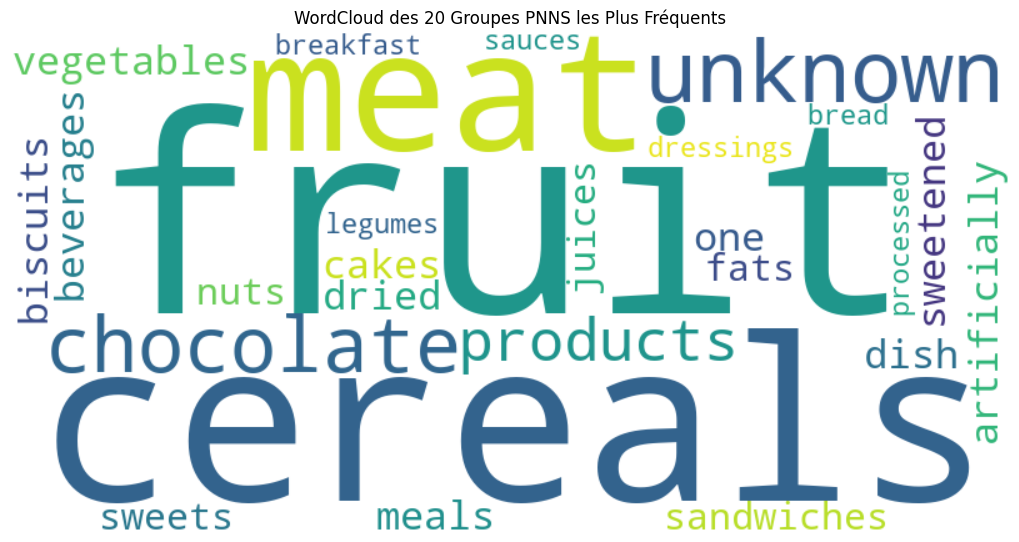

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convertir toutes les valeurs en minuscules et supprimer les espaces en trop
df_concatene_exploded['pnns_groups_2'] = df_concatene_exploded['pnns_groups_2'].str.lower().str.strip()

# Exploser les listes en lignes individuelles
df_pnns_exploded = df_concatene_exploded.explode('pnns_groups_2')

# Supprimer les espaces en trop après l'explosion
df_pnns_exploded['pnns_groups_2'] = df_pnns_exploded['pnns_groups_2'].str.strip()

# Supprimer les apostrophes (ou autres caractères indésirables) en fin de mot
df_pnns_exploded['pnns_groups_2'] = df_pnns_exploded['pnns_groups_2'].str.replace("'", "", regex=False)

# Supprimer les doublons dans la colonne pour éviter de compter plusieurs fois
df_pnns_exploded = df_pnns_exploded.drop_duplicates(subset='pnns_groups_2')

# Compter les occurrences des groupes
group_counts = df_pnns_exploded['pnns_groups_2'].value_counts()

# Sélectionner les 20 groupes les plus fréquents
top_20_groups = group_counts.head(20)

# Créer un texte géant avec uniquement les 20 groupes les plus fréquents
groups_text = ' '.join([f'{group} ' * freq for group, freq in top_20_groups.items()])

# Générer le WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(groups_text)

# Afficher le WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Pas de bordures ni d'axes
plt.title('WordCloud des 20 Groupes PNNS les Plus Fréquents')
plt.tight_layout(pad=0)
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("fichier_concatene_avecpays.csv", low_memory=False)

print(df.head())

  code           product_name           created_datetime quantity  \
0    1                  Filet  2021-10-20 15:57:36+00:00     1pcs   
1    4  Almond Dark Chocolate  2019-06-10 14:20:26+00:00     100g   
2    5             Bio inulin  2020-11-14 07:08:40+00:00     550g   
3    6         Mac and cheese  2018-11-07 21:16:26+00:00      NaN   
4    8             After burn  2021-01-05 16:06:02+00:00    10 kg   

           brands                                         categories  \
0        Body Lab                                      Proteinpulver   
1       Alter Aco                                 Dark chocolate bar   
2             EWL                                             Gemüse   
3  Chef boy r dee  Beverages and beverages preparations, Plant-ba...   
4       Afterburn                                     Protein Powder   

                                       categories_en          pnns_groups_1  \
0  Dietary supplements,Bodybuilding supplements,P...                unkno

In [13]:
# Identifier les colonnes numériques
numerical_cols = [
    'quantity', 'nutriscore_score', 'energy-kj_100g', 'energy-kcal_100g',
    'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    'nutrition-score-fr_100g'
]

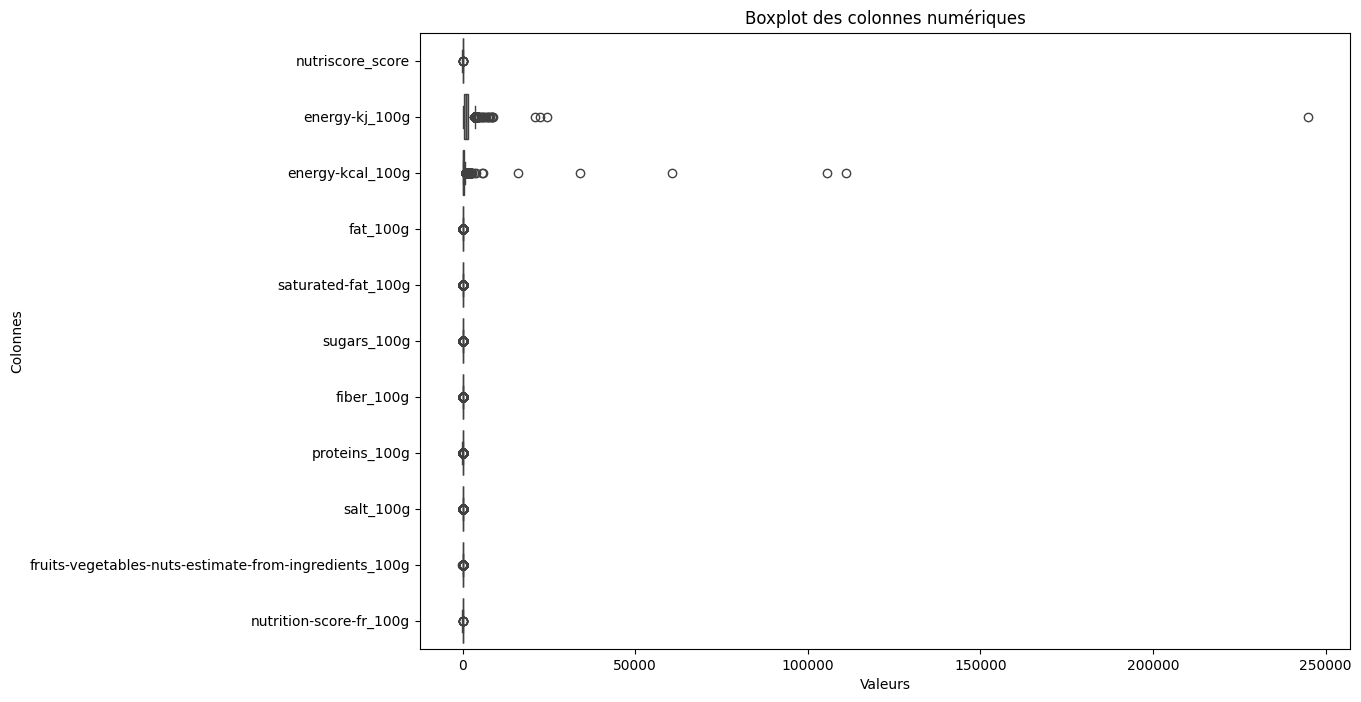

In [14]:
# Sélectionner les colonnes contenant '_100g' dans leur nom
colonnes_100g = [
    "fat_100g",
    "saturated-fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g"
]

# Filtrer les lignes où toutes les colonnes '_100g' sont inférieures ou égales à 100
df = df[(df[colonnes_100g] <= 100).all(axis=1)]

# Vérifier le résultat
# Créer un boxplot pour toutes les colonnes numériques
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_cols], orient='h')  # Orientation horizontale pour plus de lisibilité

# Ajouter des labels et un titre
plt.title('Boxplot des colonnes numériques')
plt.xlabel('Valeurs')
plt.ylabel('Colonnes')

# Afficher le plot
plt.show()
df_archive = df


In [15]:
# Calculer les valeurs du 99ème percentile pour les colonnes 'energy-kcal_100g' et 'energy-kj_100g'
percentile_99_kcal = df['energy-kcal_100g'].quantile(0.99)
percentile_99_kj = df['energy-kj_100g'].quantile(0.99)

# Filtrer les lignes où 'energy-kcal_100g' et 'energy-kj_100g' sont inférieures ou égales au 99ème percentile
df = df[(df['energy-kcal_100g'] <= percentile_99_kcal) & (df['energy-kj_100g'] <= percentile_99_kj)]

# Vérifier le résultat
print(df.head())

  code           product_name           created_datetime  \
1    4  Almond Dark Chocolate  2019-06-10 14:20:26+00:00   
2    5             Bio inulin  2020-11-14 07:08:40+00:00   
5   10      Madeleines nature  2016-10-20 07:19:01+00:00   
7   15   Madeleines ChocoLait  2018-04-15 16:43:14+00:00   
8   20  Madeleines Choco Noir  2018-09-14 13:14:06+00:00   

                 quantity     brands  \
1                    100g  Alter Aco   
2                    550g        EWL   
5                   880 g      Bijou   
7                  1080 g      Bijou   
8  1080 g / 50 madeleines      BIJOU   

                                          categories  \
1                                 Dark chocolate bar   
2                                             Gemüse   
5  Snacks, Desserts, Snacks sucrés, Biscuits et g...   
7  Snacks, Snacks sucrés, Biscuits et gâteaux, Gâ...   
8  Snacks, Snacks sucrés, Biscuits et gâteaux, Gâ...   

                                       categories_en         

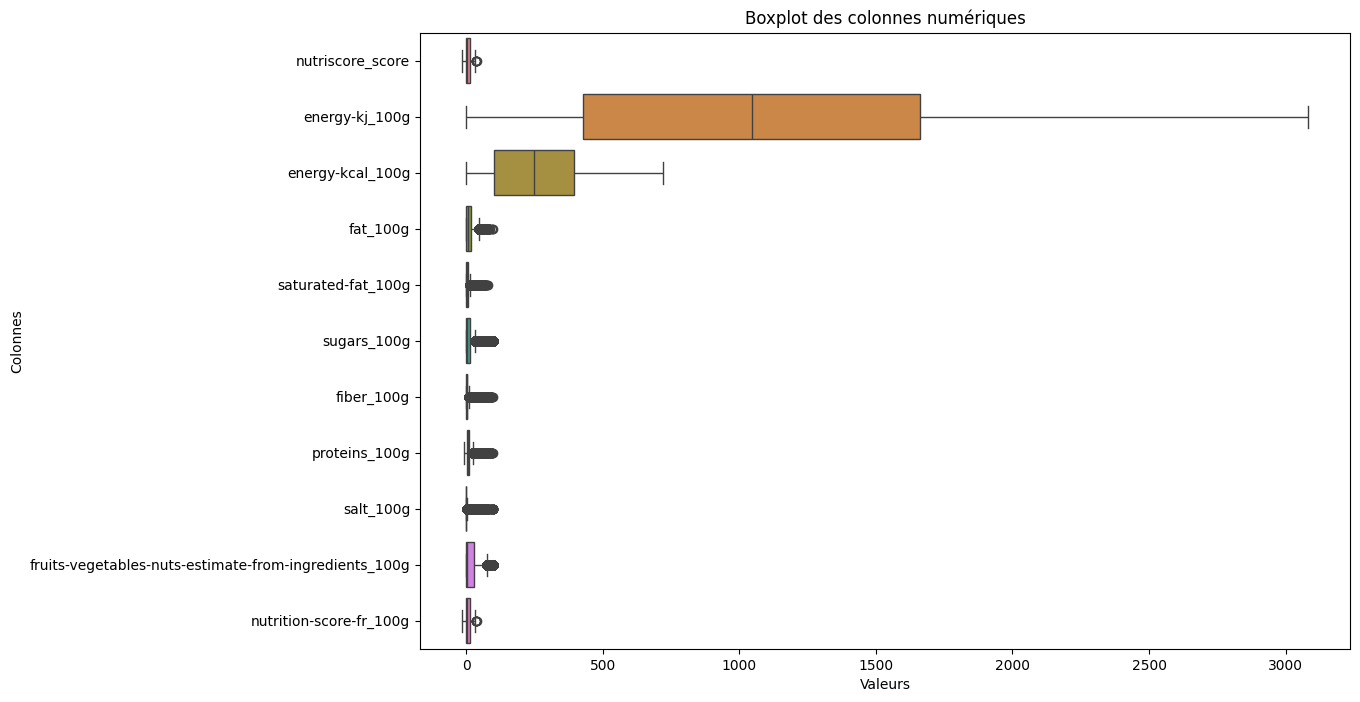

In [16]:
# Vérifier le résultat
# Créer un boxplot pour toutes les colonnes numériques
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_cols], orient='h')  # Orientation horizontale pour plus de lisibilité

# Ajouter des labels et un titre
plt.title('Boxplot des colonnes numériques')
plt.xlabel('Valeurs')
plt.ylabel('Colonnes')

# Afficher le plot
plt.show()
df_archive = df

In [17]:
max_fat_row = df.loc[df['salt_100g'].idxmax()]

# Afficher la ligne avec la valeur maximale de 'fat_100g'
print(max_fat_row)

code                                                                                         7756378000274
product_name                                                        Sal de Maras con Hierbas Mediterraneas
created_datetime                                                                 2022-07-24 21:28:32+00:00
quantity                                                                                        250 gramos
brands                                                                                                Onza
categories                                                                                    Sal de Maras
categories_en                                                                              es:sal-de-maras
pnns_groups_1                                                                                      unknown
pnns_groups_2                                                                                      unknown
main_category_en                     

Boxplot de vérification

In [18]:

# Convertir 'product_name' et 'brands' en minuscules pour ignorer la casse
df['product_name_lower'] = df['product_name'].str.lower()
df['brands_lower'] = df['brands'].str.lower()

# Supprimer les doublons en utilisant les colonnes en minuscules
df_cleaned = df.drop_duplicates(subset=['product_name_lower', 'brands_lower'], keep='first')

# Supprimer les colonnes temporaires en minuscules
df_cleaned = df_cleaned.drop(columns=['product_name_lower', 'brands_lower'])

print(df_cleaned.head())

  code           product_name           created_datetime  \
1    4  Almond Dark Chocolate  2019-06-10 14:20:26+00:00   
2    5             Bio inulin  2020-11-14 07:08:40+00:00   
5   10      Madeleines nature  2016-10-20 07:19:01+00:00   
7   15   Madeleines ChocoLait  2018-04-15 16:43:14+00:00   
8   20  Madeleines Choco Noir  2018-09-14 13:14:06+00:00   

                 quantity     brands  \
1                    100g  Alter Aco   
2                    550g        EWL   
5                   880 g      Bijou   
7                  1080 g      Bijou   
8  1080 g / 50 madeleines      BIJOU   

                                          categories  \
1                                 Dark chocolate bar   
2                                             Gemüse   
5  Snacks, Desserts, Snacks sucrés, Biscuits et g...   
7  Snacks, Snacks sucrés, Biscuits et gâteaux, Gâ...   
8  Snacks, Snacks sucrés, Biscuits et gâteaux, Gâ...   

                                       categories_en         

On enlève les doublons par marque

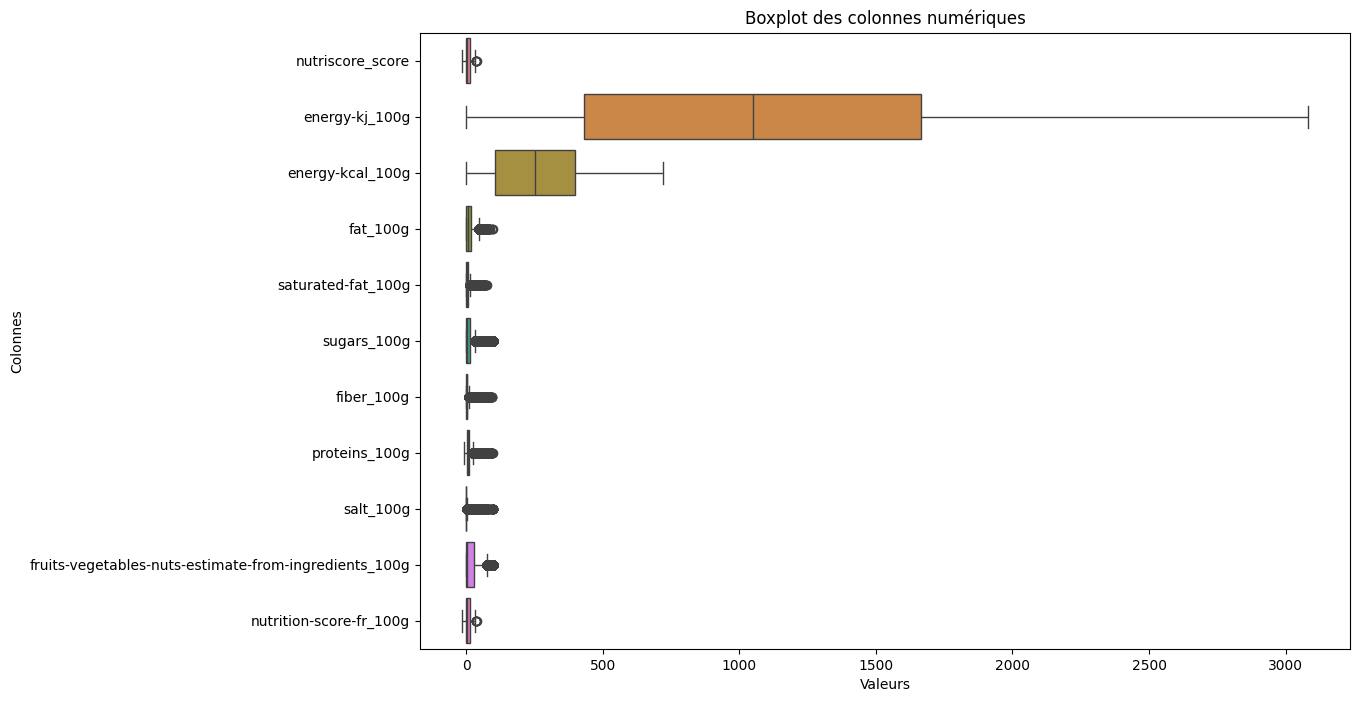

In [19]:
# Vérifier le résultat
# Créer un boxplot pour toutes les colonnes numériques
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_cols], orient='h')  # Orientation horizontale pour plus de lisibilité

# Ajouter des labels et un titre
plt.title('Boxplot des colonnes numériques')
plt.xlabel('Valeurs')
plt.ylabel('Colonnes')

# Afficher le plot
plt.show()

In [20]:
df_cleaned.describe()

,nutriscore_score,energy-kj_100g,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000,114333.000000
mean,6.208120,1105.421653,264.692317,11.927245,4.138950,11.677199,3.283319,8.184048,0.917950,21.357185,6.208120
std,8.773683,733.162114,175.507019,13.864540,6.150574,17.042442,5.005565,8.373366,2.745347,32.594158,8.773683
min,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.330000,0.000000,-2.194568,-14.000000
25%,-1.000000,433.000000,104.000000,1.200000,0.300000,1.100000,0.500000,2.400000,0.060000,0.000000,-1.000000
50%,4.000000,1051.000000,252.000000,6.500000,1.500000,3.800000,1.900000,6.400000,0.480000,2.024414,4.000000
75%,13.000000,1665.000000,397.000000,19.000000,5.300000,14.100000,4.200000,11.000000,1.100000,29.900000,13.000000
max,40.000000,3081.000000,721.000000,99.000000,76.000000,100.000000,96.000000,100.000000,100.000000,100.000000,40.000000


Enregistrement du CSV

In [21]:
df.to_csv("cleaned_data.csv", index=False)

## Dernière vérification par boxplot 

In [22]:
# Identifier les colonnes numériques
numerical_cols = [
    'quantity', 'nutriscore_score',
    'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    'nutrition-score-fr_100g'
]

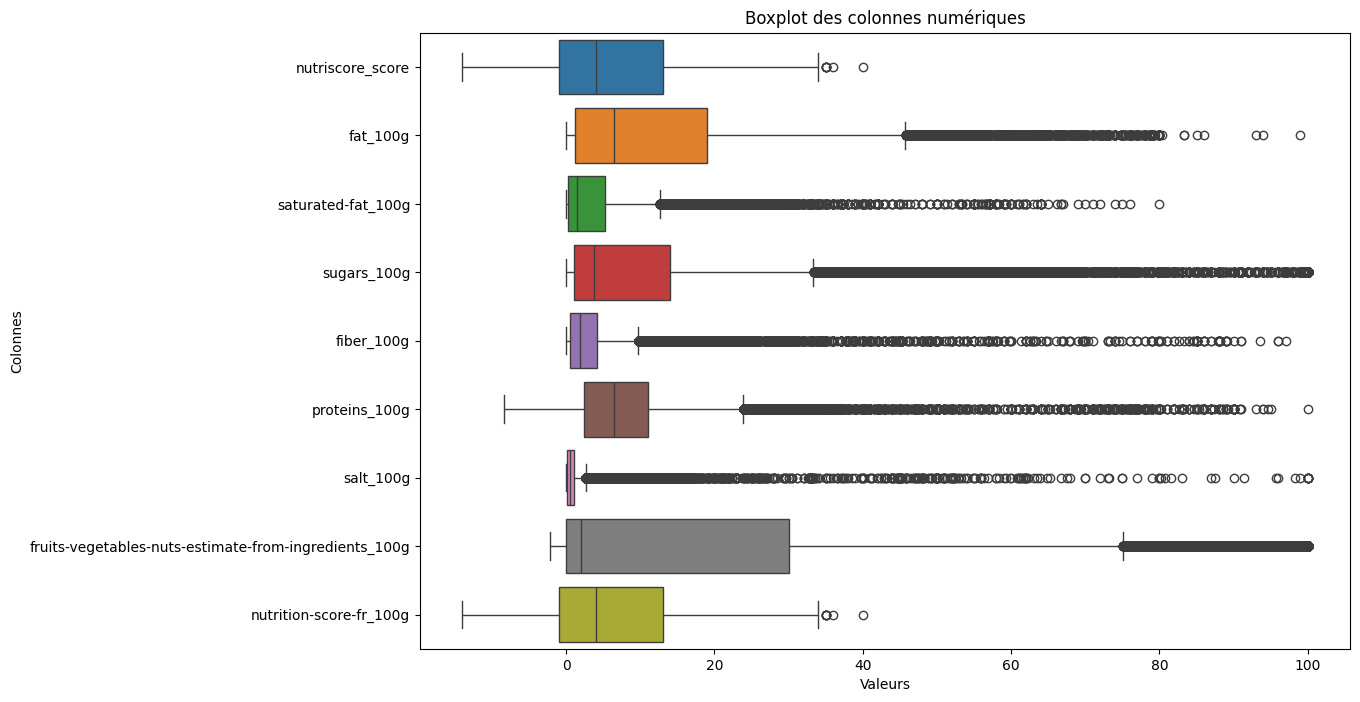

In [23]:
# Créer un boxplot pour toutes les colonnes numériques
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_cols], orient='h')  # Orientation horizontale pour plus de lisibilité

# Ajouter des labels et un titre
plt.title('Boxplot des colonnes numériques')
plt.xlabel('Valeurs')
plt.ylabel('Colonnes')

# Afficher le plot
plt.show()